## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

model_ckpt2 = ModelCheckpoint(filepath="./tmp2.h5", 
                             monitor="val_loss", 
                             save_best_only=False)

model_ckpt3 = ModelCheckpoint(filepath="./tmp3.h5", 
                             monitor="val_loss", 
                             save_weights_only=True)

In [8]:
def test_modelcheckpoint(model_ckpt,  name):
    results = {}
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "%s" % (name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    return results

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_result(results):
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], label=cond)
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], label=cond)
#     plt.hlines(y=loss_loadback, xmin=0, xmax=len(results[train_loss]), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()
        
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], label=cond)
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], label=cond)
#     plt.hlines(y=acc_loadback, xmin=0, xmax=len(results[train_loss]), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()    

In [10]:
results  = test_modelcheckpoint(model_ckpt,  'save_best_only')
results2 = test_modelcheckpoint(model_ckpt2, 'save_best_only_false')
results3 = test_modelcheckpoint(model_ckpt3, 'save_weights_only')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.4982 - acc: 0.8590 - val_loss: 1.6815 - val_acc: 0.4906
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

Epoch 49/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5058 - acc: 0.8575 - val_loss: 1.6673 - val_acc: 0.4852
Epoch 50/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.4887 - acc: 0.8647 - val_loss: 1.6906 - val_acc: 0.4838
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024     

Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5254 - acc: 0.8508 - val_loss: 1.6865 - val_acc: 0.4814
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5101 - acc: 0.8570 - val_loss: 1.6678 - val_acc: 0.4897
Epoch 50/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.4932 - acc: 0.8627 - val_loss: 1.6892 - val_acc: 0.4877


In [11]:
results_all = dict(list(results.items()) + list(results2.items()))

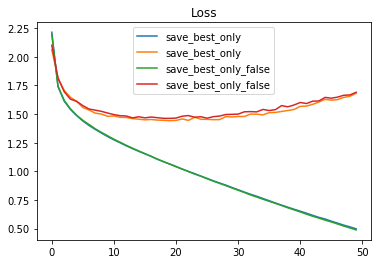

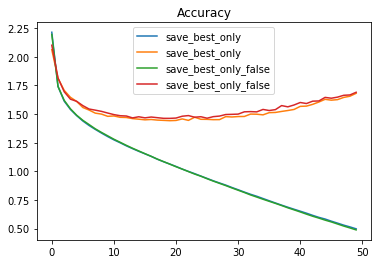

In [12]:
plot_result(results_all)

In [16]:
def plot_result_loadback(results,loss_loadback, acc_loadback):
    for i, cond in enumerate(results.keys()):
        xmax = len(results[cond]['train-loss'])
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], label=cond)
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], label=cond)
        plt.hlines(y=loss_loadback, xmin=0, xmax=xmax, colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()
        
    for i, cond in enumerate(results.keys()):
        xmax = len(results[cond]['train-loss'])
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], label=cond)
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], label=cond)
        plt.hlines(y=acc_loadback, xmin=0, xmax=xmax, colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

10000/10000 [==============================] - 1s 72us/step


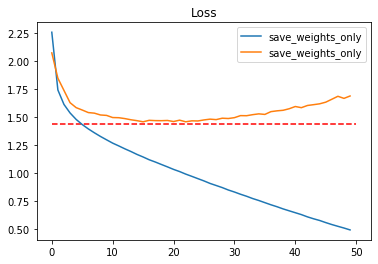

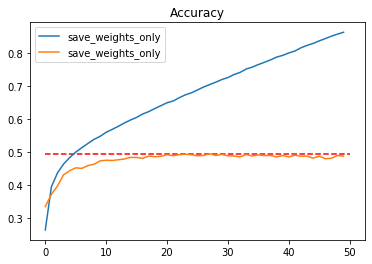

In [17]:
# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

plot_result_loadback(results3,loss_loadback, acc_loadback)